<a href="https://colab.research.google.com/github/PingPingE/Deeplearning_with_Keras/blob/master/day11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이상탐지


In [1]:
import tensorflow as tf
(X_train,_),(X_test,_) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
X_train.shape

(60000, 28, 28)

In [3]:
X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_train.reshape(-1,28,28,1)
X_train.shape

(60000, 28, 28, 1)

## 이미지에 임의로 노이즈 추가

In [5]:
X_train_noisy = X_train+0.2*tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test+0.2*tf.random.normal(shape=X_test.shape)

- 0과 1사이로 잘라내기

In [6]:
X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0, clip_value_max=1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0, clip_value_max=1.0)

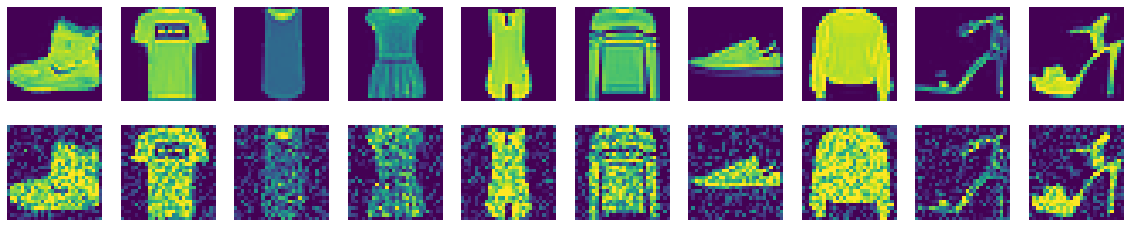

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for i in range(10):
  plt.subplot(2,10,(i+1))
  plt.imshow(X_test[i].reshape(28,28))
  plt.axis('off')

  plt.subplot(2,10,(i+1+10))
  plt.imshow(X_test_noisy[i].numpy().reshape(28,28))
  plt.axis('off')

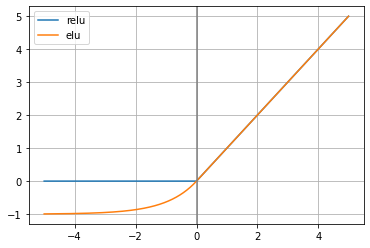

In [22]:
import math
import numpy as np
x = np.arange(-5,5,0.01)
a= 1.0
relu = [max(0,z) for z in x]
elu = [a*(np.exp(z)-1) if z<0 else z for z in x]

plt.plot(x,relu, label='relu')
plt.plot(x,elu , label='elu')
plt.axvline(0, color='gray')
plt.grid(True)
plt.legend()

---------------
- Vanishing Gradient<br>
  -> weight값을 업데이트하는 역전파 과정에서, Input 쪽으로 가까워질수록 즉, 활성화 함수의 미분값이 계속 곱해질수록 미분값이 0에 가까워져(미분값 소실) weight의 변화량이 작아지는 현상.

- ReLU함수
  1. sigmoid와 tanh에 비해서 학습속도가 훨씬 빠르고(연산이 간단하므로)
  2. exp함수를 사용하지 않아 연산비용이 크지 않고 구현이 간단하다.
  3. Vanishing Gradient현상(sigmoid, tanh) 해결
  4. But x<0인 값들에 대해 기울기가 0이므로, 몇몇 weight들이 업데이트 되지 않는 Dying ReLU현상이 발생

- ELU함수
  1. 음의 값에 대해 exp값이 추가된 함수로, ReLU함수의 Dying ReLU현상을 해결
  2. exp함수를 계산하는 연산비용이 커짐

## 모델링

### encoder 생성

In [23]:
encoder_input = tf.keras.layers.Input(shape=(28,28,1))
x= tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='elu', padding='same', strides=2)(encoder_input)
encoder_output = tf.keras.layers.Conv2D(8,(3,3), activation='elu', padding='same', strides= 2)(x)
encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


### decoder 생성

In [24]:
decoder_input = tf.keras.layers.Input(shape=(7,7,8))
x= tf.keras.layers.Conv2DTranspose(filters=32, kernel_size =(3,3), activation='elu', padding="same", strides=2)(decoder_input)
x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation="elu", padding="same", strides=2)(x)
decoder_output = tf.keras.layers.Conv2D(1,(3,3),activation='sigmoid', padding = 'same')(x)

In [25]:
decoder = tf.keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 7, 7, 8)]         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        2336      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


### autoencoder 생성

In [26]:
#encoder+decoder = autoencoder
encoder_in = tf.keras.layers.Input(shape=(28,28,1))
encoder_out = encoder(encoder_in)
decoder_out = decoder(encoder_out)

In [28]:
auto_encoder = tf.keras.Model(encoder_in, decoder_out)
auto_encoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
functional_5 (Functional)    (None, 7, 7, 8)           1320      
_________________________________________________________________
functional_7 (Functional)    (None, 28, 28, 1)         7105      
Total params: 8,425
Trainable params: 8,425
Non-trainable params: 0
_________________________________________________________________


In [29]:
auto_encoder.compile(optimizer ='adam',loss='mse')
auto_encoder.fit(X_train_noisy, X_train, epochs=10, validation_data=(X_test_noisy, X_test))

Epoch 1/10
1875/1875 [==============================] - 104s 55ms/step - loss: 0.0133 - val_loss: 0.0082
Epoch 2/10
1875/1875 [==============================] - 102s 54ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 3/10
1875/1875 [==============================] - 102s 55ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 4/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 5/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 7/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 8/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 10/10
1875/1875 [==============================] 

In [31]:
encoded_imgs = encoder(X_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

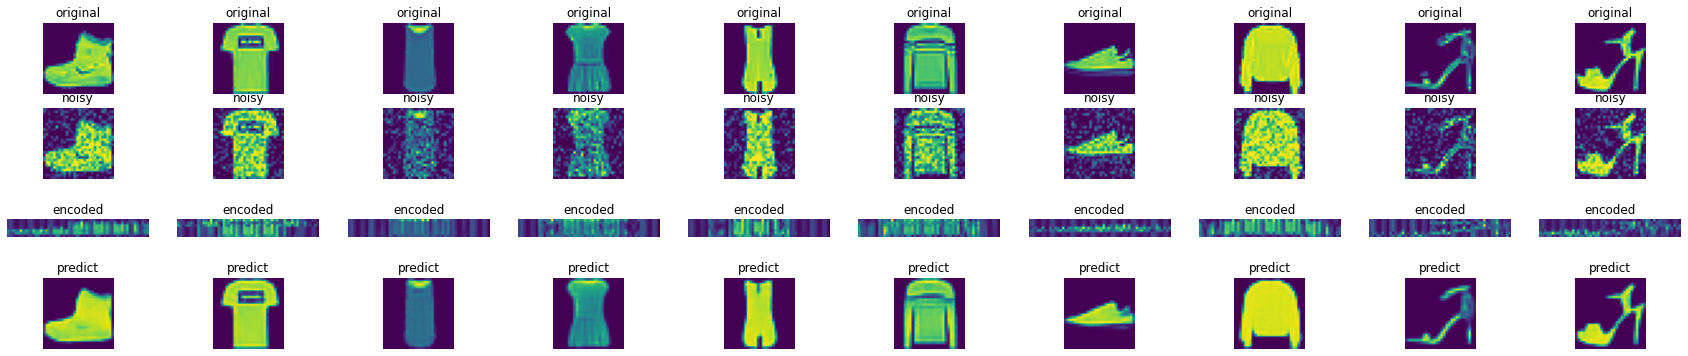

In [67]:
plt.figure(figsize=(30,6))
for i in range(10):
  plt.subplot(4,10,(i+1))
  plt.imshow(X_test[i].reshape(28,28))
  plt.title('original')
  plt.axis('off')

  plt.subplot(4,10,(i+1+10))
  plt.imshow(X_test_noisy[i].numpy().reshape(28,28))
  plt.title('noisy')
  plt.axis('off')

  plt.subplot(4,10,(i+1+20))
  plt.imshow(encoded_imgs[i].reshape(7,-1))
  plt.title('encoded')
  plt.axis('off')

  plt.subplot(4,10,(i+1+30))
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.title('predict')
  plt.axis('off')

# Case 2

In [68]:
import pandas as pd

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [69]:
labels = raw_data[:, -1]
data   = raw_data[:, 0:-1]

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state= 21)

In [74]:
X_train.shape

(3998, 140)

### 데이터 전처리 및 모델링

In [75]:
encoder_input = tf.keras.layers.Input(shape= (140,))
x= tf.keras.layers.Dense(32,activation='elu')(encoder_input)
x = tf.keras.layers.Dense(16, activation="elu")(x)
encoder_output = tf.keras.layers.Dense(8, activation="elu")(x)
encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________


In [76]:
decoder_input = tf.keras.Input(shape= (8,))
x=tf.keras.layers.Dense(16,activation='elu')(decoder_input)
x=tf.keras.layers.Dense(32, activation = 'elu')(x)
decoder_output = tf.keras.layers.Dense(140, activation="sigmoid")(x)
decoder = tf.keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 140)               4620      
Total params: 5,308
Trainable params: 5,308
Non-trainable params: 0
_________________________________________________________________


In [77]:
# encoder + decoder

encoder_in  = tf.keras.layers.Input(shape=(140,))
encoder_out = encoder(encoder_in)
decoder_out = decoder(encoder_out)
auto_incoder = tf.keras.models.Model(encoder_in, decoder_out)
auto_incoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
functional_13 (Functional)   (None, 8)                 5176      
_________________________________________________________________
functional_15 (Functional)   (None, 140)               5308      
Total params: 10,484
Trainable params: 10,484
Non-trainable params: 0
_________________________________________________________________


In [86]:
y_train = y_train.astype(bool)  # 0은 false, 1은 true로 변환

In [87]:
normal_train_data =X_train[y_train] # 정상
normal_train_data.shape

(2359, 140)

In [88]:
anomalous_train_data = X_train[~y_train] # 비정상
anomalous_train_data.shape

(1639, 140)

In [101]:
y_test = y_test.astype(bool)
normal_test_data =X_test[y_test] # 정상
normal_test_data.shape

(560, 140)

In [102]:
anomalous_test_data = X_test[~y_test] # 비정상
anomalous_test_data.shape

(440, 140)

- 정상/비정상 데이터

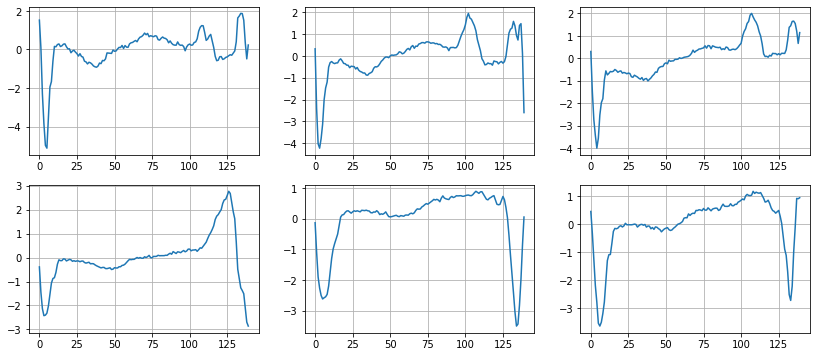

In [89]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))
for i in range(3):
  plt.subplot(2, 3, (i+1))
  plt.grid()
  plt.plot(np.arange(140), normal_train_data[i] )

  plt.subplot(2, 3, (i+1+3))
  plt.grid()
  plt.plot(np.arange(140), anomalous_train_data[i] ) 
  

### 학습

In [109]:
auto_incoder.compile(optimizer ='adam',loss='mse')
#정상데이터 학습
history = auto_incoder.fit( normal_train_data, normal_train_data, 
                           epochs=20, validation_data = (normal_test_data, normal_test_data), shuffle=True )

Epoch 1/20
74/74 [==============================] - 0s 3ms/step - loss: 0.6985 - val_loss: 0.6988
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6981 - val_loss: 0.6987
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6979 - val_loss: 0.6983
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6976 - val_loss: 0.6981
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6973 - val_loss: 0.6980
Epoch 6/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6971 - val_loss: 0.6977
Epoch 7/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6969 - val_loss: 0.6975
Epoch 8/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6968 - val_loss: 0.6971
Epoch 9/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6965 - val_loss: 0.6970
Epoch 10/20
74/74 [==============================] - 0s 2ms/step - loss: 0.6962 - val_loss: 0.6967
Epoch 11/20
74/74 [

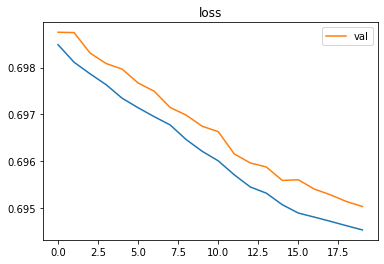

In [110]:
plt.title('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],label='val')
plt.legend()

### 결과 

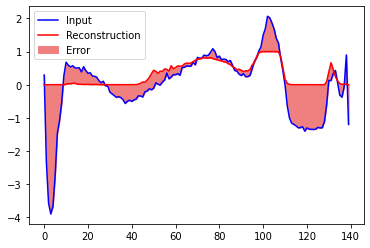

In [111]:
encoded_data = encoder(normal_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_data[0],'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

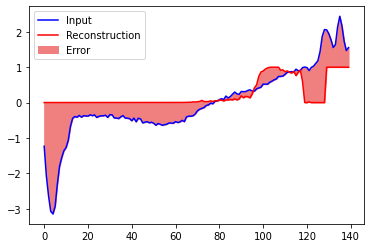

In [112]:
encoded_data = encoder(anomalous_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_data[0],'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

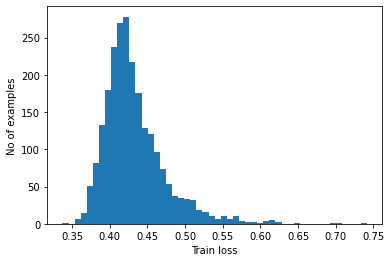

In [113]:
reconstructions = auto_incoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()


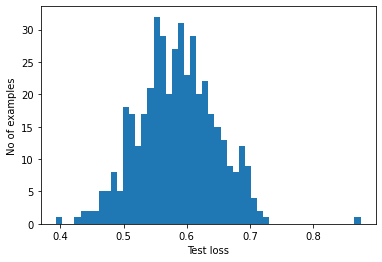

In [114]:
reconstructions = auto_incoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [115]:
np.mean(train_loss) + np.std(train_loss)

0.47400054592236046